✅ Found images:
/Users/soumya/Desktop/lung_dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (85).jpg
/Users/soumya/Desktop/lung_dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (109).jpg
/Users/soumya/Desktop/lung_dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (93).jpg
/Users/soumya/Desktop/lung_dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (50).jpg
/Users/soumya/Desktop/lung_dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (11).jpg
/Users/soumya/Desktop/lung_dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (46).jpg
/Users/soumya/Desktop/lung_dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (31).jpg
/Users/soumya/Desktop/lung_dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (89).jpg
/Users/soumya/Desktop/lung_dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (66).jpg
/Users/soumya/Desktop/lung_dataset/The IQ-OTHNC

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


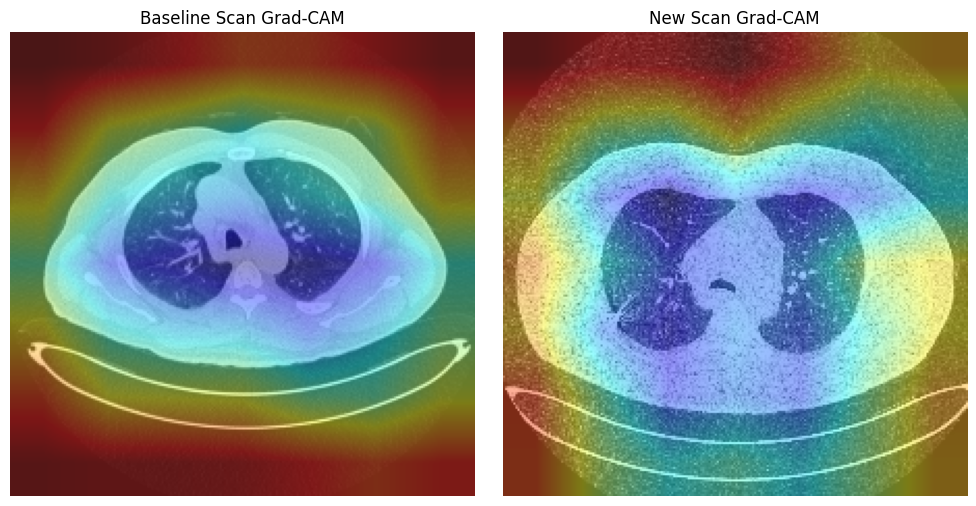

In [14]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import cv2

# ----------------- PATH TO DATASET -----------------
BASE_DIR = Path("/Users/soumya/Desktop/lung_dataset/The IQ-OTHNCCD lung cancer dataset")

# ----------------- LOAD IMAGES -----------------
# Search for all .jpg images recursively
image_files = list(BASE_DIR.rglob("*.jpg"))

# Debug: Print found images
print("✅ Found images:")
for img in image_files:
    print(img)

# Check if enough images exist
if len(image_files) < 2:
    raise FileNotFoundError(
        f"❌ Not enough .jpg images found in {BASE_DIR}. Found only {len(image_files)}."
    )

# Pick first two images automatically
baseline_path = image_files[0]
new_scan_path = image_files[1]

print(f"\n📌 Baseline scan: {baseline_path}")
print(f"📌 New scan: {new_scan_path}")

# ----------------- MODEL SETUP -----------------
# Use pre-trained MobileNetV2
model = models.mobilenet_v2(pretrained=True)
model.eval()

# ----------------- PREPROCESS FUNCTION -----------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

def preprocess_image(img_path):
    image = Image.open(img_path).convert("RGB")
    return transform(image).unsqueeze(0)

# ----------------- GRAD-CAM IMPLEMENTATION -----------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()
        self.model.zero_grad()
        output[0, class_idx].backward()

        gradients = self.gradients
        activations = self.activations
        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * activations, dim=1)
        cam = torch.relu(cam)
        cam = cam[0].detach().numpy()
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
        return cam

# ----------------- APPLY GRAD-CAM -----------------
target_layer = model.features[-1]
grad_cam = GradCAM(model, target_layer)

# Preprocess images
baseline_tensor = preprocess_image(baseline_path)
new_scan_tensor = preprocess_image(new_scan_path)

# Generate CAMs
baseline_cam = grad_cam.generate(baseline_tensor)
new_cam = grad_cam.generate(new_scan_tensor)

# ----------------- VISUALIZATION -----------------
def show_cam_on_image(img_path, cam):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = heatmap * 0.4 + img * 0.6
    plt.imshow(np.uint8(overlay))
    plt.axis("off")

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title("Baseline Scan Grad-CAM")
show_cam_on_image(baseline_path, baseline_cam)

plt.subplot(1,2,2)
plt.title("New Scan Grad-CAM")
show_cam_on_image(new_scan_path, new_cam)

plt.tight_layout()
plt.show()